<a href="https://colab.research.google.com/github/utkarshkant/Multiple-Time-Series-Modelling-with-PySpark-and-FB-Prophet/blob/main/Multiple_Time_Series_Modelling_with_PySpark_and_FB_Prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multiple Time Series Modelling with Apache Spark and FB Prophet

In [2]:
# install java 8 compatible with Apache Spark
!apt-get install -y openjdk-8-jdk-headless -qq > /dev/null
import os
os.environ["JAVA HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
!update-alternatives --set java /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java

update-alternatives: using /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java to provide /usr/bin/java (java) in manual mode


In [3]:
# check java version
!java -version

openjdk version "1.8.0_265"
OpenJDK Runtime Environment (build 1.8.0_265-8u265-b01-0ubuntu2~18.04-b01)
OpenJDK 64-Bit Server VM (build 25.265-b01, mixed mode)


In [4]:
# install pyspark
!pip install pyspark

     |████████████████████████████████| 204.2MB 72kB/s 
     |████████████████████████████████| 204kB 43.0MB/s 
  Created wheel for pyspark: filename=pyspark-3.0.1-py2.py3-none-any.whl size=204612243 sha256=414c033330a05ea2f690169ff25b781ef89a9c784ba16417485573329f855873
  Stored in directory: /root/.cache/pip/wheels/5e/bd/07/031766ca628adec8435bb40f0bd83bb676ce65ff4007f8e73f
Successfully built pyspark


In [5]:
# install pyarrow
!pip install pyarrow==0.15.1  # package for transferring data from one technology to another

     |████████████████████████████████| 59.2MB 75kB/s 
  Found existing installation: pyarrow 0.14.1
    Uninstalling pyarrow-0.14.1:
      Successfully uninstalled pyarrow-0.14.1


In [6]:
# install fbprophet
!pip install fbprophet

In [7]:
# standard imports
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from fbprophet import Prophet   # for time series modelling

# configurations
mpl.rcParams['figure.figsize'] = (10,8)
mpl.rcParams['axes.grid'] = False
sns.set_style("whitegrid")

In [8]:
# initializing a spark session
from pyspark.sql import SparkSession
import pyspark
spark = SparkSession.builder.master('local').getOrCreate()

In [9]:
# load dataset
df = pd.read_csv('https://raw.githubusercontent.com/utkarshkant/Multiple-Time-Series-Modelling-with-PySpark-and-FB-Prophet/main/weekly_sales_data')

In [10]:
# preview dataset
df

,date,store_id,sales
0,1/6/2019,25,736657.2267
1,1/6/2019,26,233711.0000
2,1/6/2019,28,692156.3794
3,1/6/2019,29,213706.8000
4,1/6/2019,30,266455.0000
...,...,...,...
495,12/15/2019,31,401803.3590
496,12/15/2019,35,135799.1429
497,12/15/2019,38,115424.2250
498,12/15/2019,41,103375.0000


In [11]:
# size of dataset
print("# Rows:", df.shape[0])
print("# Cols:", df.shape[1])

# Rows: 500
# Cols: 3


In [12]:
# metadata
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   date      500 non-null    object 
 1   store_id  500 non-null    int64  
 2   sales     500 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 11.8+ KB


- Data contains weekly sales data, i.e., the weekly sales per store id
- `date` feature is not in datetime format

In [13]:
# check for missing values
df.isnull().sum()

date        0
store_id    0
sales       0
dtype: int64

- no missing data found

In [14]:
# convert 'date' feature into datetime
df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True)

In [15]:
# metadata
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      500 non-null    datetime64[ns]
 1   store_id  500 non-null    int64         
 2   sales     500 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 11.8 KB


In [16]:
# unique values
df.nunique()

date         50
store_id     10
sales       500
dtype: int64

- there are 50 unique date values and 
- 10 unique store ids

We will build 10 different time-series models for the 10 different store ids and run them together

In [17]:
# create a backup copy of the dataset
df_1 = df.copy()

In [18]:
# metadata
df.describe()

,store_id,sales
count,500.0000,5.000000e+02
mean,32.7000,4.470800e+05
std,6.1714,2.970660e+05
min,25.0000,1.278800e+04
25%,28.0000,2.526557e+05
50%,30.5000,3.150259e+05
75%,38.0000,6.845418e+05
max,44.0000,1.631585e+06


In [19]:
# explore features
df['store_id'].value_counts()

44    50
41    50
38    50
35    50
31    50
30    50
29    50
28    50
26    50
25    50
Name: store_id, dtype: int64

- each store has data records

In [20]:
# set date as index
df_ts = df.set_index('date')

In [21]:
# preview dataset
df_ts

,store_id,sales
date,,
2019-01-06,25,736657.2267
2019-01-06,26,233711.0000
2019-01-06,28,692156.3794
2019-01-06,29,213706.8000
2019-01-06,30,266455.0000
...,...,...
2019-12-15,31,401803.3590
2019-12-15,35,135799.1429
2019-12-15,38,115424.2250


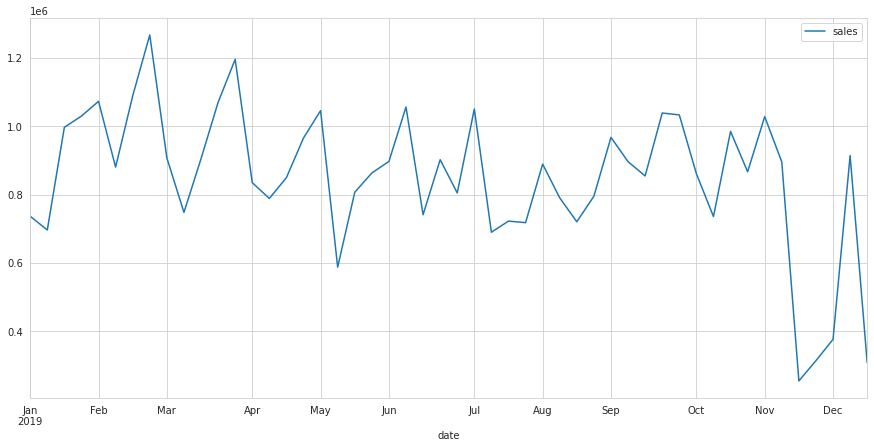

In [22]:
# explore individual stores
plt.figure(figsize=(15,7))
df_ts.query("store_id==25")['sales'].plot(legend=True)

- Multiple peaks and troughs on monthly basis
- Sharp dip nearing year-end in November

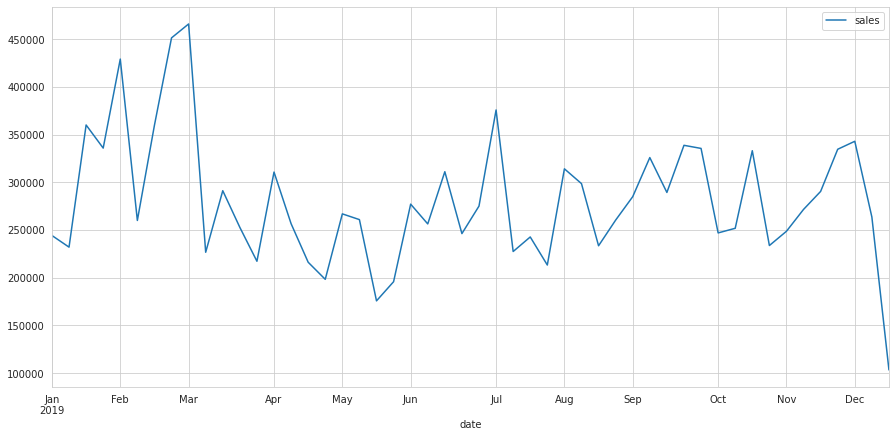

In [23]:
# explore individual stores
plt.figure(figsize=(15,7))
df_ts.query("store_id==41")['sales'].plot(legend=True)

- Multiple peaks and troughs on monthly basis
- No sharp dip nearing year-end in November

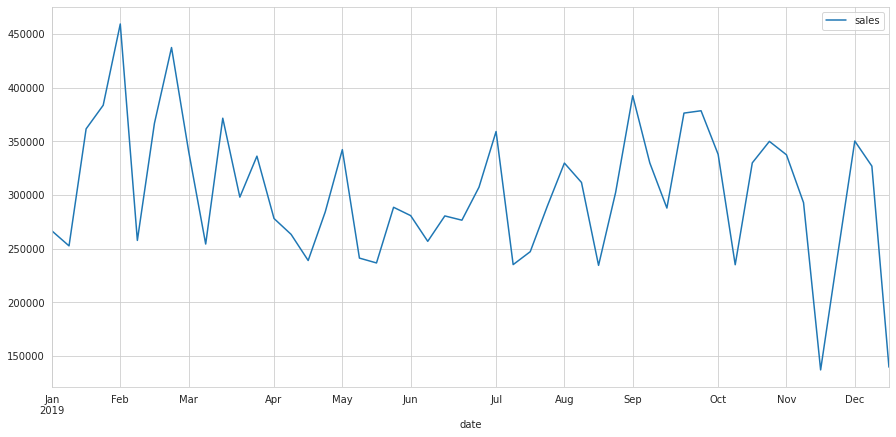

In [24]:
# explore individual stores
plt.figure(figsize=(15,7))
df_ts.query("store_id==30")['sales'].plot(legend=True)

- The time series for each store is different from one another
- Therefore, each store requires its individual time-series model

Build Spark Components

In [25]:
# build spark dataframe
sdf = spark.createDataFrame(df)

In [26]:
# preview spark dataframe
sdf.show(5)

+-------------------+--------+-----------+
|               date|store_id|      sales|
+-------------------+--------+-----------+
|2019-01-06 00:00:00|      25|736657.2267|
|2019-01-06 00:00:00|      26|   233711.0|
|2019-01-06 00:00:00|      28|692156.3794|
|2019-01-06 00:00:00|      29|   213706.8|
|2019-01-06 00:00:00|      30|   266455.0|
+-------------------+--------+-----------+
only showing top 5 rows



In [27]:
# metadata
sdf.printSchema()

root
 |-- date: timestamp (nullable = true)
 |-- store_id: long (nullable = true)
 |-- sales: double (nullable = true)



In [28]:
# size of dataset
sdf.count()

500

In [29]:
# data records per store
sdf.select(['store_id']).groupBy('store_id').agg({"store_id":"count"}).show()

+--------+---------------+
|store_id|count(store_id)|
+--------+---------------+
|      26|             50|
|      29|             50|
|      31|             50|
|      25|             50|
|      41|             50|
|      28|             50|
|      44|             50|
|      35|             50|
|      38|             50|
|      30|             50|
+--------+---------------+



Now we need to partition the spark data into multiple partitions based on the store ids

In [30]:
# create temporary spark view
sdf.createOrReplaceTempView("sales")

In [31]:
spark.sql("SELECT store_id, COUNT(*) FROM sales GROUP BY store_id ORDER BY store_id").show()

+--------+--------+
|store_id|count(1)|
+--------+--------+
|      25|      50|
|      26|      50|
|      28|      50|
|      29|      50|
|      30|      50|
|      31|      50|
|      35|      50|
|      38|      50|
|      41|      50|
|      44|      50|
+--------+--------+



In [32]:
# create a SQL query
sql = "SELECT store_id, date AS ds, SUM(sales) as y FROM sales GROUP BY store_id, ds ORDER BY store_id, ds"

In [33]:
# preview data
spark.sql(sql).show()

+--------+-------------------+------------------+
|store_id|                 ds|                 y|
+--------+-------------------+------------------+
|      25|2019-01-06 00:00:00|       736657.2267|
|      25|2019-01-13 00:00:00|       696457.1717|
|      25|2019-01-20 00:00:00|        996876.875|
|      25|2019-01-27 00:00:00|        1029737.05|
|      25|2019-02-03 00:00:00|       1072873.705|
|      25|2019-02-10 00:00:00|       880462.4681|
|      25|2019-02-17 00:00:00|        1088756.78|
|      25|2019-02-24 00:00:00|       1266928.313|
|      25|2019-03-03 00:00:00|       907510.1217|
|      25|2019-03-10 00:00:00|       747920.9824|
|      25|2019-03-17 00:00:00|       904750.3158|
|      25|2019-03-24 00:00:00|1069857.5890000002|
|      25|2019-03-31 00:00:00|       1195574.314|
|      25|2019-04-07 00:00:00|       834911.3333|
|      25|2019-04-14 00:00:00|       788777.4167|
|      25|2019-04-21 00:00:00|       849603.4333|
|      25|2019-04-28 00:00:00|        965521.165|


- feature names `ds` and `y` is a requirement of `fbprophet`

In [34]:
sdf.explain()   # it has an RDD function

== Physical Plan ==
*(1) Scan ExistingRDD[date#0,store_id#1L,sales#2]




In [35]:
# check data partitions
sdf.rdd.getNumPartitions()

1

- data is still in a single partition
- we need to divide it into multiple partitions


In [36]:
# create internal cache to prevent repeated data fetching
store_part = (spark.sql(sql).repartition(spark.sparkContext.defaultParallelism, ['store_id'])).cache()

In [37]:
store_part

DataFrame[store_id: bigint, ds: timestamp, y: double]

In [38]:
store_part.explain()

== Physical Plan ==
InMemoryTableScan [store_id#1L, ds#83, y#84]
   +- InMemoryRelation [store_id#1L, ds#83, y#84], StorageLevel(disk, memory, deserialized, 1 replicas)
         +- Exchange hashpartitioning(store_id#1L, 1), false, [id=#147]
            +- *(3) Sort [store_id#1L ASC NULLS FIRST, ds#83 ASC NULLS FIRST], true, 0
               +- Exchange rangepartitioning(store_id#1L ASC NULLS FIRST, ds#83 ASC NULLS FIRST, 200), true, [id=#143]
                  +- *(2) HashAggregate(keys=[store_id#1L, date#0], functions=[sum(sales#2)])
                     +- Exchange hashpartitioning(store_id#1L, date#0, 200), true, [id=#139]
                        +- *(1) HashAggregate(keys=[store_id#1L, date#0], functions=[partial_sum(sales#2)])
                           +- *(1) Scan ExistingRDD[date#0,store_id#1L,sales#2]




- Multiple data partitions have been created



In [39]:
# create a schema

# import datatypes
from pyspark.sql.types import *
# create schema
result_schema = StructType([
                            StructField('ds', TimestampType()),
                            StructField('store_id', IntegerType()),
                            StructField('y', DoubleType()),
                            StructField('yhat', DoubleType()),
                            StructField('yhat_upper', DoubleType()),
                            StructField('yhat_lower', DoubleType())
                          ])

In [40]:
# UDF for fbprophet modelling
from pyspark.sql.functions import pandas_udf, PandasUDFType

@pandas_udf(result_schema, PandasUDFType.GROUPED_MAP)   # GROUPED_MAP allows you to vectorize group of rows from data
def forecast_sales(store_pd):
  # create fbprophet model
  model = Prophet(interval_width=0.95, # forecast with 95% confidence interval
                  seasonality_mode='multiplicative',  # because multiple peaks and troughs in data
                  weekly_seasonality=True,
                  yearly_seasonality=True)
  # train model
  model.fit(store_pd)

  # future dataframe - for how much time in future do you wish to forecast
  future_pd = model.make_future_dataframe(
      periods=5,  # forecast for next 5 periods/values
      freq='w'    # weekly forecast
  )

  # make forecast
  forecast_pd = model.predict(future_pd)

  # store results
  f_pd = forecast_pd[['ds', 'yhat', 'yhat_upper', 'yhat_lower']].set_index('ds')
  st_pd = store_pd[['ds', 'store_id', 'y']].set_index('ds')

  # create result dataframe
  results_pd = f_pd.join(st_pd, how='left')
  results_pd.reset_index(level=0, inplace=True)
  results_pd['store_pd'] = store_pd['store_id'].iloc[0]

  return results_pd[['ds', 'store_id', 'y', 'yhat', 'yhat_upper', 'yhat_lower']]

In [41]:
# append current date to store when you run this model
from pyspark.sql.functions import current_date

results = (
    store_part
      .groupBy('store_id')  # vectorize the columns
      .apply(forecast_sales)  # apply UDF
      .withColumn('training_date', current_date())
)

/usr/local/lib/python3.6/dist-packages/pyspark/sql/pandas/group_ops.py:76: UserWarning:

It is preferred to use 'applyInPandas' over this API. This API will be deprecated in the future releases. See SPARK-28264 for more details.



In [42]:
results.cache()

DataFrame[ds: timestamp, store_id: int, y: double, yhat: double, yhat_upper: double, yhat_lower: double, training_date: date]

In [43]:
# preview results
results.show(5)

+-------------------+--------+-----------+------------------+------------------+------------------+-------------+
|                 ds|store_id|          y|              yhat|        yhat_upper|        yhat_lower|training_date|
+-------------------+--------+-----------+------------------+------------------+------------------+-------------+
|2019-01-06 00:00:00|      25|736657.2267| 712575.0694095818| 964091.7223007476|486577.19159198273|   2020-10-07|
|2019-01-13 00:00:00|      25|696457.1717| 743751.7568979745| 979890.6595385578| 501378.2937120345|   2020-10-07|
|2019-01-20 00:00:00|      25| 996876.875| 972909.8778074606|1185029.2643246108| 738883.5986192742|   2020-10-07|
|2019-01-27 00:00:00|      25| 1029737.05|1034447.5557655566|1256880.3327057916| 798864.3835934855|   2020-10-07|
|2019-02-03 00:00:00|      25|1072873.705| 986365.7266813249| 1214181.404062533| 757418.1006287117|   2020-10-07|
+-------------------+--------+-----------+------------------+------------------+--------

In [44]:
# collate all partitions into 1 partition
results.coalesce(1)

DataFrame[ds: timestamp, store_id: int, y: double, yhat: double, yhat_upper: double, yhat_lower: double, training_date: date]

In [45]:
# size of results
results.count()   # 5 weeks forecast for 10 stores, thus, 550 (500+50)

550

In [46]:
# create temp view
results.createOrReplaceTempView('forecasted')

In [47]:
# sql query to fetch results
spark.sql("SELECT store_id, COUNT(*) FROM forecasted GROUP BY store_id").show()

+--------+--------+
|store_id|count(1)|
+--------+--------+
|      31|      50|
|      28|      50|
|      26|      50|
|      44|      50|
|    null|      50|
|      41|      50|
|      35|      50|
|      38|      50|
|      25|      50|
|      29|      50|
|      30|      50|
+--------+--------+



- The null is for forecasted values

In [48]:
# convert spark DF to pandas
final_df = results.toPandas()
final_df

,ds,store_id,y,yhat,yhat_upper,yhat_lower,training_date
0,2019-01-06,25.0,7.366572e+05,7.125751e+05,9.640917e+05,486577.191592,2020-10-07
1,2019-01-13,25.0,6.964572e+05,7.437518e+05,9.798907e+05,501378.293712,2020-10-07
2,2019-01-20,25.0,9.968769e+05,9.729099e+05,1.185029e+06,738883.598619,2020-10-07
3,2019-01-27,25.0,1.029737e+06,1.034448e+06,1.256880e+06,798864.383593,2020-10-07
4,2019-02-03,25.0,1.072874e+06,9.863657e+05,1.214181e+06,757418.100629,2020-10-07
...,...,...,...,...,...,...,...
545,2019-12-22,NaN,NaN,6.265474e+04,1.269201e+05,-3924.519869,2020-10-07
546,2019-12-29,NaN,NaN,2.657442e+04,8.700684e+04,-37232.431873,2020-10-07
547,2020-01-05,NaN,NaN,8.801264e+03,7.093800e+04,-52601.231193,2020-10-07
548,2020-01-12,NaN,NaN,4.665900e+03,6.635060e+04,-62753.186888,2020-10-07


In [49]:
# create date as index
final_df = final_df.set_index('ds')

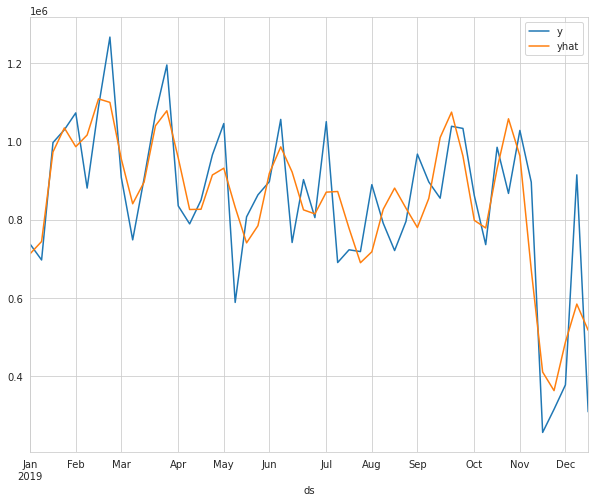

In [54]:
# explore individual stores
final_df.query("store_id==25")[['y', 'yhat']].plot(legend=True)

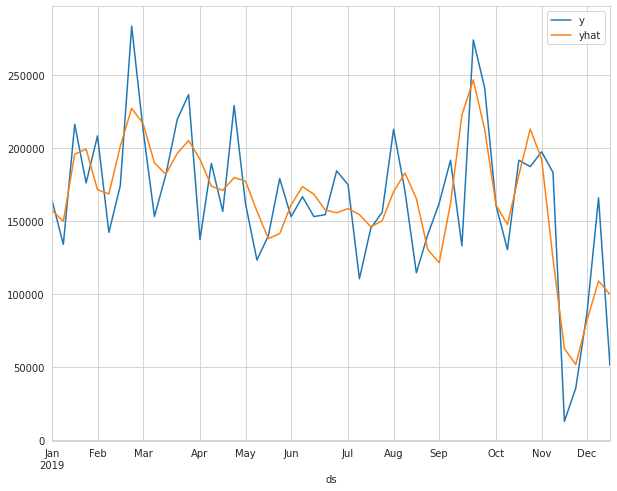

In [55]:
# explore individual stores
final_df.query("store_id==44")[['y', 'yhat']].plot(legend=True)

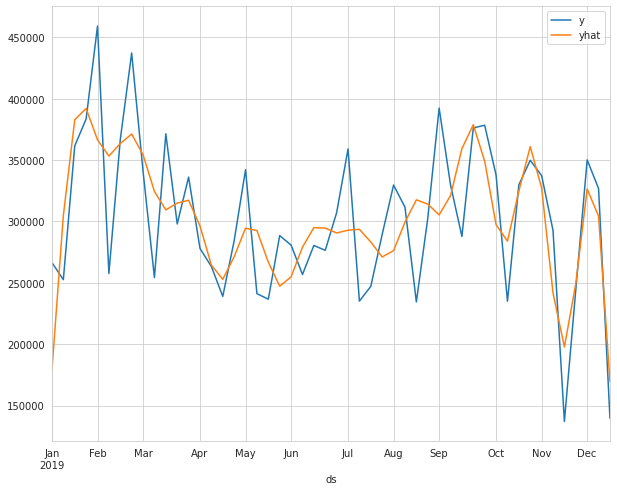

In [56]:
# explore individual stores
final_df.query("store_id==30")[['y', 'yhat']].plot(legend=True)